# Spotify Hit Prediction: Technical Report
Contributors: Kyle Manning, Blake Rosenthal  
Class: CPSC 322, Spring 2022

## Introduction
This [dataset we are working with](https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset) consists of songs/tracks fetched using Spotify's Web API. Each track is labeled as a 'Hit' or 'Flop' according to the following criteria defined by the author of the dataset:

> target: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.
>
> The author's condition of a track being 'flop' is as follows:
>
>- The track must not appear in the 'hit' list of that decade.
>- The track's artist must not appear in the 'hit' list of that decade.
>- The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
>- The track's genre must not have a song in the 'hit' list.
>- The track must have 'US' as one of its markets.

This is the class label we are trying to predict.  
In the end, we found the Naive Bayes classifier approach performing the best with, for example, an accuracy of 70.5%.

## Data Analysis
This dataset contains, across six different .csv files (each pertaining to a different decade), over 40,000 instances.  
Each instance has 19 different attributes:  
- 3 of these attributes (track name, artist name, Spotify uri) are mostly irrelevant for the task at hand
- 15 of these attributes (including danceability, energy, loudness, acousticness, instrumentalness, tempo, duration, time signature, etc.) could potentially help us with this classification task
- 1 attribute is the 'target' attribute, A.K.A. the class label ('Hit' or 'Flop')  
It is also worth noting that, very beneficially, the dataset is clean (no missing attribute values) and contains a 50/50 split of 'Hits' and 'Flops'.  
Before analyzing the dataset, we need to reduce its size, as 40,000+ instances will be too computationally expensive (especially for certain classifiers).  
In reducing its size, we also decided to limit our work to the 2010s and 2000s datasets. We figured this would be a better classification task, as the type of music that breaks into the 'mainstream' is likely quite different decade to decade.  
We also made sure when reducing the dataset size to maintain the 50/50 'Hit' and 'Flop' split.

### Data Preprocessing

In [1]:
import importlib
from tabulate import tabulate

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

In [2]:
pytable_10s = MyPyTable().load_from_file("input_data/dataset-of-10s.csv")
pytable_00s = MyPyTable().load_from_file("input_data/dataset-of-00s.csv")
# pytable_90s = MyPyTable().load_from_file("input_data/dataset-of-90s.csv")
# pytable_80s = MyPyTable().load_from_file("input_data/dataset-of-80s.csv")
# pytable_70s = MyPyTable().load_from_file("input_data/dataset-of-70s.csv")
# pytable_60s = MyPyTable().load_from_file("input_data/dataset-of-60s.csv")

# Need to reduce the size of our dataset for the sake of computing efficiency
# We want an equal distribution of "Hits" and "Flops"
# As well as an equal distribution of tracks between the 2010s and the 2000s

_, target_subtables_10s = myutils.group_by(pytable_10s.data, pytable_10s.column_names, "target")
_, target_subtables_00s = myutils.group_by(pytable_00s.data, pytable_00s.column_names, "target")
# _, target_subtables_90s = myutils.group_by(pytable_90s.data, pytable_90s.column_names, "target")
# _, target_subtables_80s = myutils.group_by(pytable_80s.data, pytable_80s.column_names, "target")
# _, target_subtables_70s = myutils.group_by(pytable_70s.data, pytable_70s.column_names, "target")
# _, target_subtables_60s = myutils.group_by(pytable_60s.data, pytable_60s.column_names, "target")

reduced_size_table = []
for i in range(500):
    reduced_size_table.append(target_subtables_10s[0][i])
    reduced_size_table.append(target_subtables_10s[1][i])
    reduced_size_table.append(target_subtables_00s[0][i])
    reduced_size_table.append(target_subtables_00s[1][i])
    # reduced_size_table.append(target_subtables_90s[0][i])
    # reduced_size_table.append(target_subtables_90s[1][i])
    # reduced_size_table.append(target_subtables_80s[0][i])
    # reduced_size_table.append(target_subtables_80s[1][i])
    # reduced_size_table.append(target_subtables_70s[0][i])
    # reduced_size_table.append(target_subtables_70s[1][i])
    # reduced_size_table.append(target_subtables_60s[0][i])
    # reduced_size_table.append(target_subtables_60s[1][i])


### EDA / Feature Selection
Through our exploratory data analysis detailed below, we determined that we should use the danceability, energy, valence, and tempo attributes for classification.  
The EDA below depicts histograms that display the distributions of each of these 4 attributes in both 'Hits' and 'Flops'.

In [3]:
_, target_subtables = myutils.group_by(reduced_size_table, pytable_10s.column_names, "target")
flop_subtable = target_subtables[0].copy()
hit_subtable = target_subtables[1].copy()

#### Danceability
Figures 1 and 2 below show us that 'Hits' typically have a higher danceability rating than 'Flops' do.  
For 'Hits', they congregate mostly around the 0.5-0.8 mark, while 'Flops' are more spread out.

##### Flop Danceability Distribution

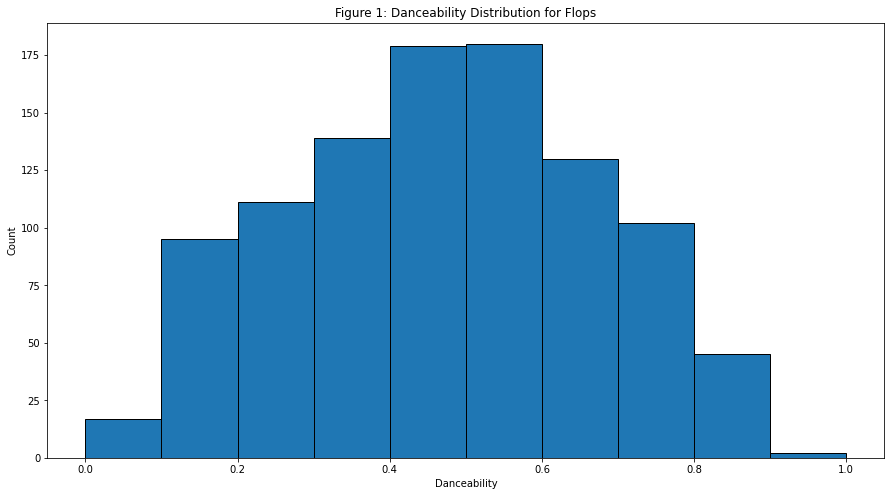

In [4]:
flop_danceability_col = myutils.get_column(flop_subtable, known_col_index=3)
plot_utils.draw_histogram("Figure 1: Danceability Distribution for Flops", "Danceability", "Count",
    flop_danceability_col, 10, (0.0, 1.0))

##### Hit Danceability Distribution

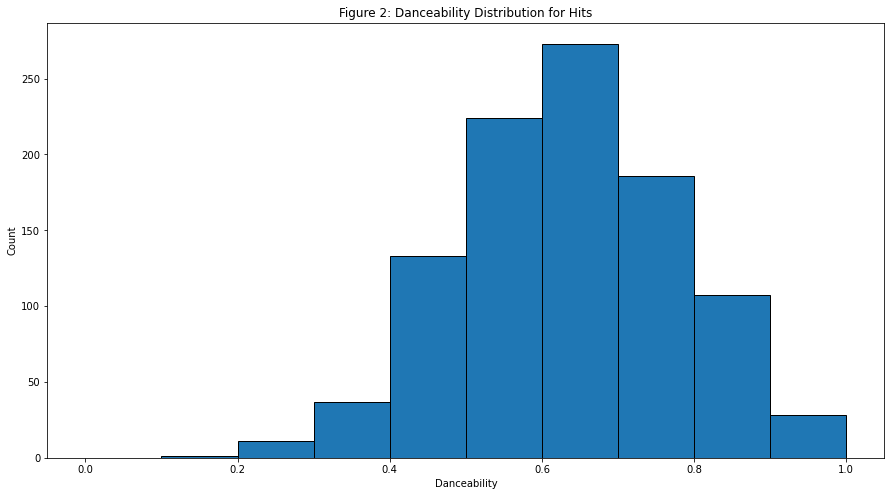

In [5]:
hit_danceability_col = myutils.get_column(hit_subtable, known_col_index=3)
plot_utils.draw_histogram("Figure 2: Danceability Distribution for Hits", "Danceability", "Count",
    hit_danceability_col, 10, (0.0, 1.0))

#### Energy
Figure 3 below was a bit surprising for us. Intuitively, we imagined that 'Flops' would typically have a lower energy rating, but there appears to be a large group of them around the 0.9-1.0 mark. In reflection, this may be explained by the fact that there are plenty of genres with extremely high energy, but not the type of energy that mainstream audiences are looking for (i.e. power metal).  
Either way, comparing this chart to Figure 4 shows that energy is a good metric for classification.

##### Flop Energy Distribution

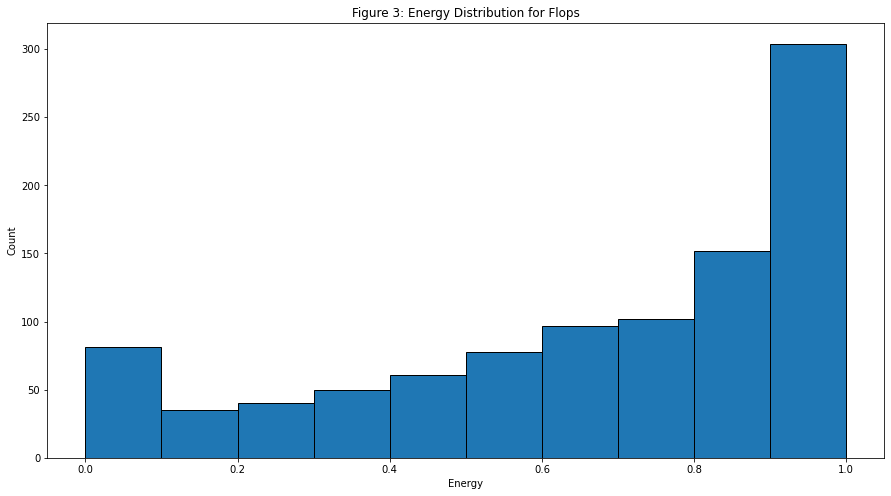

In [6]:
flop_energy_col = myutils.get_column(flop_subtable, known_col_index=4)
plot_utils.draw_histogram("Figure 3: Energy Distribution for Flops", "Energy", "Count",
    flop_energy_col, 10, (0.0, 1.0))

##### Hit Energy Distribution

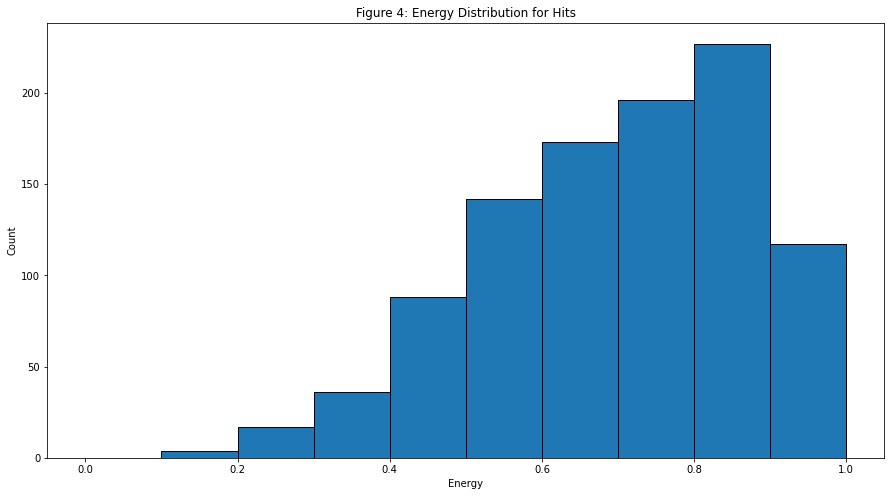

In [7]:
hit_energy_col = myutils.get_column(hit_subtable, known_col_index=4)
plot_utils.draw_histogram("Figure 4: Energy Distribution for Hits", "Energy", "Count",
    hit_energy_col, 10, (0.0, 1.0))

#### Valence
Figures 5 and 6 below display that 'Flops' typically have a lower valence rating ('valence' meaning positivity/happiness) than 'Hits' do, which intuitively seems logical.

##### Flop Valence Distribution

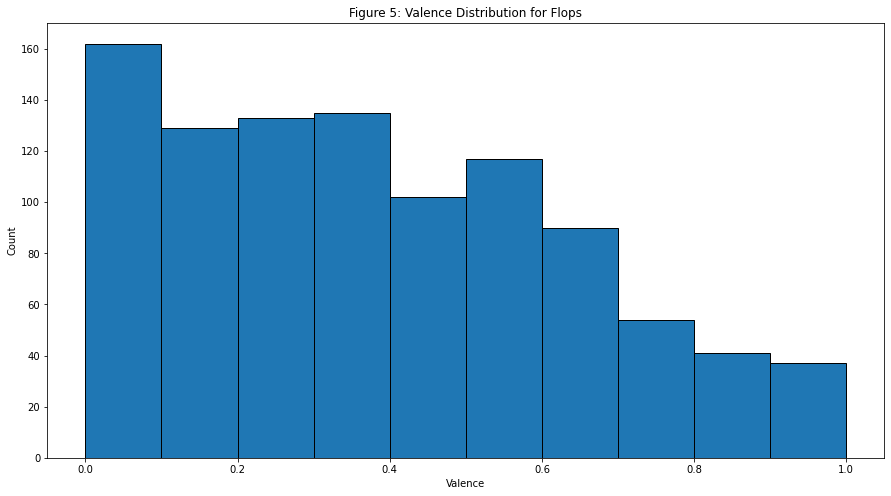

In [8]:
flop_valence_col = myutils.get_column(flop_subtable, known_col_index=12)
plot_utils.draw_histogram("Figure 5: Valence Distribution for Flops", "Valence", "Count",
    flop_valence_col, 10, (0.0, 1.0))

##### Hit Valence Distribution

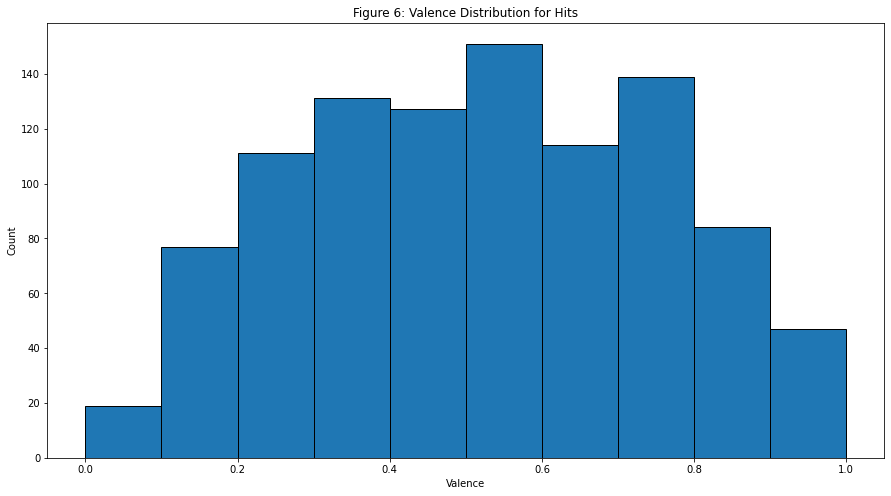

In [9]:
hit_valence_col = myutils.get_column(hit_subtable, known_col_index=12)
plot_utils.draw_histogram("Figure 6: Valence Distribution for Hits", "Valence", "Count",
    hit_valence_col, 10, (0.0, 1.0))

#### Tempo
Figures 7 and 8 below display that the distribution of tempos for 'Flops' skews slightly lower than the distribution of tempos for 'Hits'.  
In particular, the bin with the highest count for 'Flops' hovers around the 100 bpm mark; in contrast, for 'Hits' it is the bin hovering around the 125 bpm mark.

##### Flop Tempo Distribution

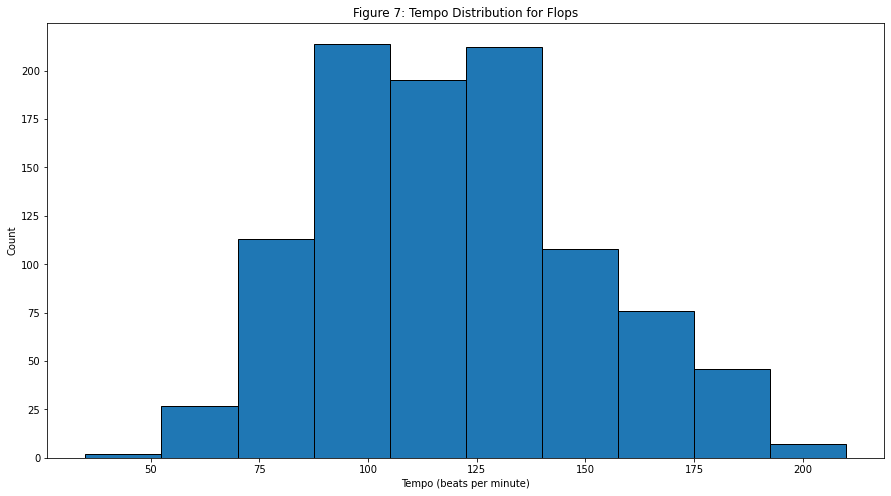

In [10]:
flop_tempo_col = myutils.get_column(flop_subtable, known_col_index=13)
plot_utils.draw_histogram("Figure 7: Tempo Distribution for Flops", "Tempo (beats per minute)", "Count",
    flop_tempo_col, 10, (35, 210))

##### Hit Tempo Distribution

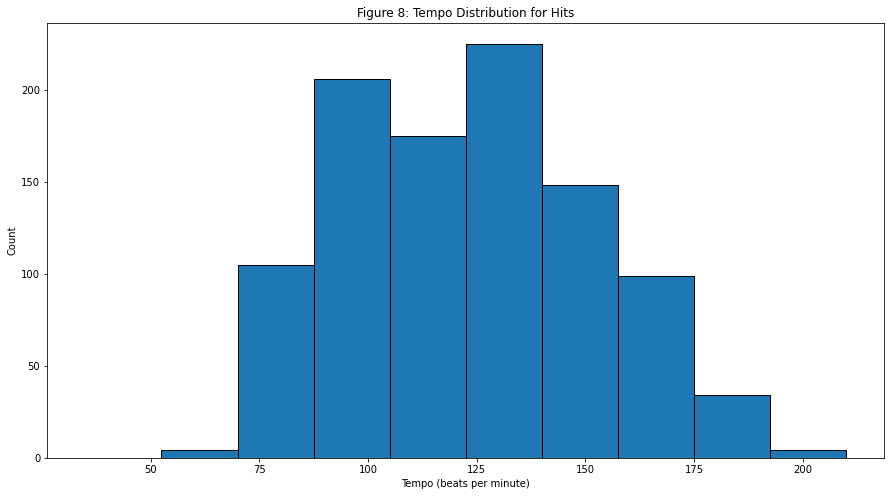

In [11]:
hit_tempo_col = myutils.get_column(hit_subtable, known_col_index=13)
plot_utils.draw_histogram("Figure 8: Tempo Distribution for Hits", "Tempo (beats per minute)", "Count",
    hit_tempo_col, 10, (35, 210))

## Classification Results
The following classifiers are evaluated down below: kNN (with k=3 and k=5), Naive Bayes, and Decision Tree.  
Unfortunately, our attempted random forest implementation did not pan out, so it is not included in this project.  

Each classifier was evaluated using stratified 10-fold cross validation to ensure that the 50/50 'Hit' and 'Flop' class split was maintained.  
The performance metrics used to compare the classifiers include accuracy, precision, recall, and F1 score. We believe accuracy is the most significant metric here, as detection of 'Hits' and detection of 'Flops' are likely of nearly equal importance, but the other metrics are still provided for a well-rounded analysis. Additionally, all these metrics are fit for a binary classification task like this.  

For kNN classification, tempo needed to be normalized so as to not have excessive influence on the classification results. As such, the tempo (in beats per minute) of each track was converted to an appropriately-scaled decimal value between 0.0 and 1.0, just like how danceability, energy, and valence are scaled.  
Meanwhile, for Naive Bayes and Decision Tree classification, discretization was needed. As such, the danceability, energy, valence, and normalized tempo ratings for each track were converted to integers between 1 and 5 (0.0-0.2 = 1, 0.2-0.4 = 2, 0.4-0.6 = 3, etc.).  

Overall, we found that all of the classifiers were quite close in performance. For example, the worst-performing classifier was kNN (k=3) with an accuracy of 68%, while the best-performing classifier was Naive Bayes with an accuracy of 70.5%. All of the classifiers performed well-above the results that a Dummy classifier would give (a 50% accuracy due to the 50/50 class split in the dataset).  
Since Naive Bayes was the best-performing classifier, we created a Flask web app utilizing it for 'Hit' or 'Flop' predictions. The instructions on how to run this web app are in the 'README.md' file.

In [12]:
matrix_header = ["Class", "Hit", "Flop"]

tempo_col = myutils.get_column(reduced_size_table, known_col_index=13) # Needed for normalization
X_data = ([[track[3], track[4], track[12], myutils.normalize_tempo_value(track[13], min(tempo_col), max(tempo_col))]
    for track in reduced_size_table])
y_data = [track[-1] for track in reduced_size_table]

### kNN Classifier, k=3

In [13]:
knn_classifier = MyKNeighborsClassifier()
print("k Nearest Neighbors Classifier w/ Stratified 10-Fold Cross Validation")
accuracy, error_rate, precision, recall, f1, knn_y_true, knn_y_pred = myevaluation.do_cross_validation(10,
    X_data, y_data, knn_classifier, stratified=True, pos_label=1.0)
print("accuracy:", accuracy)
print("error rate:", error_rate)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)
knn_matrix = myevaluation.confusion_matrix(knn_y_true, knn_y_pred, [1.0, 0.0])
knn_matrix[0].insert(0, "Hit")
knn_matrix[1].insert(0, "Flop")
print(tabulate(knn_matrix, headers=matrix_header))

k Nearest Neighbors Classifier w/ Stratified 10-Fold Cross Validation
accuracy: 0.68
error rate: 0.31999999999999995
precision: 0.6675977653631285
recall: 0.717
f1: 0.6914175506268081
Class      Hit    Flop
-------  -----  ------
Hit        717     283
Flop       357     643


### kNN Classifier, k=5

In [14]:
knn_classifier = MyKNeighborsClassifier(n_neighbors=5)
print("k Nearest Neighbors Classifier w/ Stratified 10-Fold Cross Validation")
accuracy, error_rate, precision, recall, f1, knn_y_true, knn_y_pred = myevaluation.do_cross_validation(10,
    X_data, y_data, knn_classifier, stratified=True, pos_label=1.0)
print("accuracy:", accuracy)
print("error rate:", error_rate)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)
knn_matrix = myevaluation.confusion_matrix(knn_y_true, knn_y_pred, [1.0, 0.0])
knn_matrix[0].insert(0, "Hit")
knn_matrix[1].insert(0, "Flop")
print(tabulate(knn_matrix, headers=matrix_header))

k Nearest Neighbors Classifier w/ Stratified 10-Fold Cross Validation
accuracy: 0.6865
error rate: 0.3135
precision: 0.6651904340124003
recall: 0.751
f1: 0.7054955378111789
Class      Hit    Flop
-------  -----  ------
Hit        751     249
Flop       378     622


### Naive Bayes Classifier

In [15]:
discretized_X_data = ([[myutils.discretize_value(instance[0]), myutils.discretize_value(instance[1]),
    myutils.discretize_value(instance[2]), myutils.discretize_value(instance[3])] for instance in X_data])

In [16]:
nb_classifier = MyNaiveBayesClassifier()
print("Naive Bayes Classifier w/ Stratified 10-Fold Cross Validation")
accuracy, error_rate, precision, recall, f1, nb_y_true, nb_y_pred = myevaluation.do_cross_validation(10,
    discretized_X_data, y_data, nb_classifier, stratified=True, pos_label=1.0)
print("accuracy:", accuracy)
print("error rate:", error_rate)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)
nb_matrix = myevaluation.confusion_matrix(nb_y_true, nb_y_pred, [1.0, 0.0])
nb_matrix[0].insert(0, "Hit")
nb_matrix[1].insert(0, "Flop")
print(tabulate(nb_matrix, headers=matrix_header))

Naive Bayes Classifier w/ Stratified 10-Fold Cross Validation
accuracy: 0.705
error rate: 0.29500000000000004
precision: 0.6708333333333333
recall: 0.805
f1: 0.7318181818181817
Class      Hit    Flop
-------  -----  ------
Hit        805     195
Flop       395     605


### Decision Tree Classifier

In [17]:
dt_classifier = MyDecisionTreeClassifier()
print("Decision Tree Classifier w/ Stratified 10-Fold Cross Validation")
accuracy, error_rate, precision, recall, f1, dt_y_true, dt_y_pred = myevaluation.do_cross_validation(10,
    discretized_X_data, y_data, dt_classifier, stratified=True, pos_label=1.0)
print("accuracy:", accuracy)
print("error rate:", error_rate)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)
dt_matrix = myevaluation.confusion_matrix(dt_y_true, dt_y_pred, [1.0, 0.0])
dt_matrix[0].insert(0, "Hit")
dt_matrix[1].insert(0, "Flop")
print(tabulate(dt_matrix, headers=matrix_header))

Decision Tree Classifier w/ Stratified 10-Fold Cross Validation
accuracy: 0.703
error rate: 0.29700000000000004
precision: 0.6691666666666667
recall: 0.803
f1: 0.73
Class      Hit    Flop
-------  -----  ------
Hit        803     197
Flop       397     603


## Conclusion
In summary, this project revolved around utilizing a dataset of Spotify tracks in order to predict whether a particular track would be a 'Hit' (mainstream, commercial success) or a 'Flop'.  
The main challenge of this classification task was dealing with the large scope of the dataset (40,000+ tracks/instances and 19 attributes per track).  

Our approach involved utilizing exploratory data analysis in order to determine which track attributes to use in classification.  
From there, each classifier was evaluated using stratified 10-fold cross validation, with normalization as well as discretization of different attributes being carried out as necessary.  

The classifiers were all very close in performance, but the 70.5% accuracy of the Naive Bayes classifier managed to just barely beat out the 70.3% accuracy of the Decision Tree classifier.  

In terms of improving classifier performance, an idea that comes to mind is refining the attribute/feature selection. With the decently large number of attributes in this dataset, it is likely that there are at least a few more of them that make for good class label predictors. For example, the 'chorus_hit' attribute (which is an "estimate of when the chorus would start for the track") might be worth investigating, as many popular songs are known to bring in the catchy chorus quickly in order to get people's attention.